In [1]:
# Common
from datetime import datetime #=> date time conversion on dataframe
import re
 
# Dataframe
import pandas as pd
 
# Numerical
import numpy as np
from math import sqrt
 
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns #plotting
 
# Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, r2_score
from keras.layers.recurrent import GRU
from keras import optimizers
import tensorflow as tf
 
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
 
pd.options.mode.chained_assignment = None  #https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html

### Function

In [2]:
def fit_model(train, val, timesteps, hl, lr, batch, epochs):
  '''
  Split data train ==> X_train & y_train
  Split data validasi ==> X_val & y_val
  Inisiasi model neural network (RNN LSTM)
  Fitting/ Training data

  Parameter:
    train = dataframe train (yang belum dipisah X & y)
    val = dataframe validasi (yang belum dipisah X & y)
    timesteps = sequence
    hl = hidden layer
    lr = learning rate
    batch = mini batch untuk iterasi
    epochs = jumlah iterasi

  Returns:
    model = model LSTM hasil training
    model[loss] = nilai loss hasil training
    model[val_loss] = nilai loss hasil validasi
  '''
  X_train = []
  Y_train = []
  X_val = []
  Y_val = []

  # Loop for training data
  # Index: 0 (Open), 1 (High), 2 (Low), ...6 (Close)
  for i in range(timesteps,train.shape[0]):
      X_train.append(train[i-timesteps:i]) # List
      Y_train.append(train[i][6]) # <== Index 6 (CLOSE) bisa juga -1
  X_train, Y_train = np.array(X_train), np.array(Y_train) # Transform list to numpy array

  # Loop for val data
  for i in range(timesteps,val.shape[0]):
      X_val.append(val[i-timesteps:i])
      Y_val.append(val[i][6]) # <== Index 6 (CLOSE), bisa juga -1
  X_val, Y_val = np.array(X_val), np.array(Y_val)
  
  # Setting up an early stop
  earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
  callbacks_list = [earlystop]
  
  # Adding Layers to the model
  model = Sequential()
  model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                  activation = 'relu'))
  
  # Hidden layer
  for i in range(len(hl)-1):        
      model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
      model.add(Dropout(0.2))
  
  # Hidden layer
  model.add(LSTM(hl[-1],activation = 'relu'))
  model.add(Dropout(0.2))

  #output mode
  model.add(Dense(1))
  
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr), loss = 'mean_squared_error')
  #print(model.summary())

  # Training the data
  history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 1,
                      shuffle = False, callbacks=callbacks_list)
  model.reset_states()
  return model, history.history['loss'], history.history['val_loss'], history

In [3]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
  X_test = []
  Y_test = []

  # Loop for testing data
  for i in range(timesteps,test.shape[0]):
      X_test.append(test[i-timesteps:i])
      Y_test.append(test[i][6]) # <== Index 3 (CLOSE)
  X_test,Y_test = np.array(X_test), np.array(Y_test)

  # Prediction Time !!!!
  Y_hat = model.predict(X_test)
  mse = mean_squared_error(Y_test,Y_hat)
  rmse = sqrt(mse)
  r = r2_score(Y_test,Y_hat)
  return  mse, rmse, r, Y_test, Y_hat

In [4]:
# Plotting the predictions
def plot_data(Y_test,Y_hat,test_data=None):
  # date = test_data.reset_index()['Date']
  plt.plot(Y_test,c = 'r')
  plt.plot(Y_hat,c = 'y')
  plt.xlabel('Day')
  plt.ylabel('Price')
  plt.title('Stock Prediction Graph using Multivariate-LSTM model')
  plt.legend(['Actual','Predicted'],loc = 'lower right')
  plt.show()

In [5]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
  plt.plot(train_loss,c = 'r')
  plt.plot(val_loss,c = 'b')
  plt.ylabel('Loss')
  plt.legend(['train','val'],loc = 'upper right')
  plt.show()

In [6]:
df = pd.read_csv('Output_micro_CPIN.csv')
df['Date'] = pd.to_datetime(df['Date'])
print(f'{np.min(df.Date)} until {np.max(df.Date)}')

# Extracting the series
df = df.set_index('Date')
# df = jkl.set_index('Date')
df = df.dropna() # Drop menghindari Explosion Gradient (LSTM syarat: non NaN)

# Picking the multivariate series 
variables = ['Open','High','Low','PER', 'PBV', 'ROE', 'Close']
#series = df[['OpenV', 'HighV', 'LowV', 'Close', 'BI-7Day-RR', 'Data Inflasi', 'Kurs']] 
series = df[variables] 
print(series.shape)
print(series)

2015-03-31 00:00:00 until 2020-12-30 00:00:00
(1444, 7)
              Open    High     Low         PER       PBV        ROE   Close
Date                                                                       
2015-03-31  3575.0  3575.0  3490.0  134.790000  5.080000   3.770000  3545.0
2015-04-01  3475.0  3500.0  3410.0  133.825385  5.066703   3.819011  3435.0
2015-04-02  3415.0  3430.0  3365.0  132.860769  5.053407   3.868022  3370.0
2015-04-06  3375.0  3435.0  3375.0  129.002308  5.000220   4.064066  3425.0
2015-04-07  3455.0  3630.0  3440.0  128.037692  4.986923   4.113077  3615.0
...            ...     ...     ...         ...       ...        ...     ...
2020-12-22  6950.0  7000.0  6600.0   29.089333  4.559556  15.925111  6650.0
2020-12-23  6650.0  6825.0  6275.0   28.930667  4.562111  15.993222  6600.0
2020-12-28  6600.0  6800.0  6475.0   28.137333  4.574889  16.333778  6775.0
2020-12-29  6800.0  6850.0  6525.0   27.978667  4.577444  16.401889  6600.0
2020-12-30  6600.0  6625.0  6325

#### Modelling

In [7]:
import datetime as dt
# Note : 2015-3-31 00:00:00 until 2020-12-30 00:00:00 
# Train Data
train_start = dt.date(2015,3,31)
train_end = dt.date(2019,3,31)
train_data = series.loc[train_start:train_end] # Output Train Data

# Validation Data
val_start = dt.date(2019,4,1)
val_end = dt.date(2020,5,23)
val_data = series.loc[val_start:val_end] # Output Validation Data

# Test Data
test_start = dt.date(2020,5,24)
test_end = dt.date(2020,12,30)
test_data = series.loc[test_start:test_end] # Output Test Data

print(f"Data train {train_start}:{train_end}")
print(f"Data validation {val_start}:{val_end}")
print(f"Data test {test_start}:{test_end}")
print()
print(train_data.shape,val_data.shape,test_data.shape)

# ROT: 70-20-10

Data train 2015-03-31:2019-03-31
Data validation 2019-04-01:2020-05-23
Data test 2020-05-24:2020-12-30

(1009, 7) (289, 7) (146, 7)


In [8]:
# Normalisation
# StadardScaler, RobustScaler
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(1009, 7) (289, 7) (146, 7)


In [9]:
# LSTM Hyperparameters
timesteps = 3
hl = [32,32]
lr = 0.001
batch_size = 128
num_epochs = 25

Epoch 1/25
8/8 [==============================] - 5s 95ms/step - loss: 0.1321 - val_loss: 0.3307
Epoch 2/25
8/8 [==============================] - 0s 12ms/step - loss: 0.1176 - val_loss: 0.3043
Epoch 3/25
8/8 [==============================] - 0s 11ms/step - loss: 0.1031 - val_loss: 0.2747
Epoch 4/25
8/8 [==============================] - 0s 12ms/step - loss: 0.0872 - val_loss: 0.2408
Epoch 5/25
8/8 [==============================] - 0s 12ms/step - loss: 0.0703 - val_loss: 0.2021
Epoch 6/25
8/8 [==============================] - 0s 12ms/step - loss: 0.0523 - val_loss: 0.1587
Epoch 7/25
8/8 [==============================] - 0s 11ms/step - loss: 0.0372 - val_loss: 0.1144
Epoch 8/25
8/8 [==============================] - 0s 11ms/step - loss: 0.0258 - val_loss: 0.0767
Epoch 9/25
8/8 [==============================] - 0s 12ms/step - loss: 0.0218 - val_loss: 0.0522
Epoch 10/25
8/8 [==============================] - 0s 13ms/step - loss: 0.0221 - val_loss: 0.0416
Epoch 11/25
8/8 [============

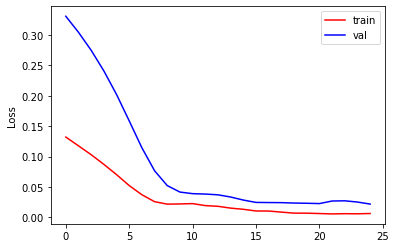

In [10]:
model, train_error, val_error, history = fit_model(train, val, timesteps, hl, lr, batch_size, num_epochs) #training
plot_error(train_error,val_error)

In [11]:
mse, rmse, r2_value, true,predicted = evaluate_model(model, test, timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))

MSE = 0.05411647155314142
RMSE = 0.2326294726666022
R-Squared Score = -24.93799457291312


In [12]:
mse, rmse, r2_value, true,predicted = evaluate_model(model, test, timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))

# Create empty dimension to fit with the scaler that has been trained by n dimensions
inverted_true = pd.DataFrame(true)
inverted_pred = pd.DataFrame(predicted)
for i in range(test_data.shape[1]-1):
  inverted_true[i+1] = np.nan
  inverted_pred[i+1] = np.nan

# Inverse Transform
true_inverse = sc.inverse_transform(inverted_true)
predicted_inverse = sc.inverse_transform(inverted_pred)

#plot_data(true_inverse, predicted_inverse, test_data[-true.shape[0]:])

MSE = 0.05411647155314142
RMSE = 0.2326294726666022
R-Squared Score = -24.93799457291312


In [13]:
# Get each date data
train_date = train_data.index
val_date = val_data.index
test_date = test_data.index[timesteps:]

# Bring back onto original values
train_sc = sc.inverse_transform(train)
val_sc = sc.inverse_transform(val)
test_sc = sc.inverse_transform(test)

# Create empty fill so predicted data fits with scaler dimension
zeros_shape = test.shape[0] - timesteps
num_x_variables = len(variables) - 1
empty_fill = np.zeros((zeros_shape, num_x_variables))

# Transform back into original value
pred = np.concatenate((empty_fill, predicted), axis=1)
pred = sc.inverse_transform(pred)

In [14]:
mse, rmse, r2_value, true,predicted = evaluate_model(model, test, timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))

MSE = 0.05411647155314142
RMSE = 0.2326294726666022
R-Squared Score = -24.93799457291312


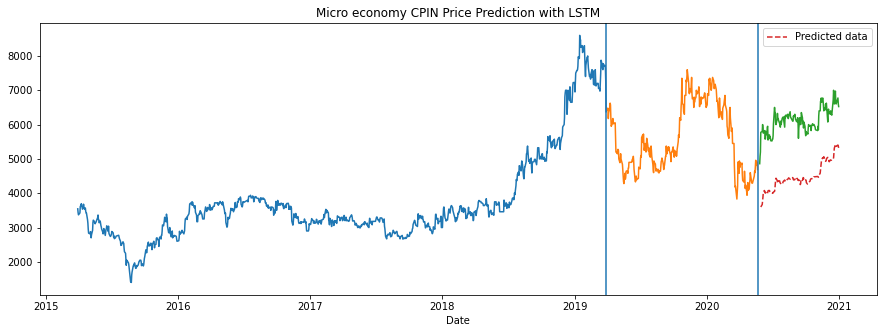

In [15]:
# Figure size
plt.figure(figsize=(15, 5))

# Train data
plt.plot(train_date, train_sc[:, -1])

# Val data
plt.plot(val_date, val_sc[:, -1])

# Test data
plt.plot(test_data.index, test_sc[:, -1])
plt.plot(test_date, pred[:, -1], label='Predicted data', linestyle='--')

# Boundaries
plt.axvline(np.max(train_date))
plt.axvline(np.max(val_date))

# Attributes
plt.title('Micro economy CPIN Price Prediction with LSTM')
plt.xlabel('Date')
plt.legend()
plt.show()

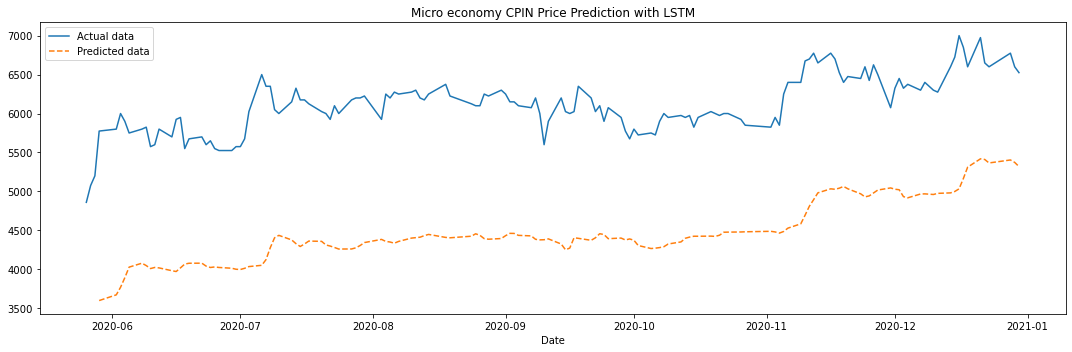

In [16]:
plt.figure(figsize=(15, 5))

# Test data
plt.plot(test_data.index, test_sc[:, -1], label='Actual data')
plt.plot(test_date, pred[:, -1], label='Predicted data', linestyle='--')

# Attributes
plt.title('Micro economy CPIN Price Prediction with LSTM')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()

## GRU

In [17]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
  X_train = []
  Y_train = []
  X_val = []
  Y_val = []

  # Loop for training data
  for i in range(timesteps,train.shape[0]):
      X_train.append(train[i-timesteps:i])
      Y_train.append(train[i][6])
  X_train,Y_train = np.array(X_train),np.array(Y_train)
  print(X_train.shape)
  # Loop for val data
  for i in range(timesteps,val.shape[0]):
      X_val.append(val[i-timesteps:i])
      Y_val.append(val[i][6])
  X_val,Y_val = np.array(X_val),np.array(Y_val)

  # Setting up an early stop
  earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=150,  verbose=1, mode='min')
  callbacks_list = [earlystop]
  
  # Adding Layers to the model
  model = Sequential()

  # Arsitektur 
  model.add(GRU(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                activation = 'relu'))
  
  for i in range(len(hl)-1):        
      model.add(GRU(hl[i],activation = 'relu',return_sequences = True))
      model.add(Dropout(0.2))
        
  model.add(GRU(hl[-1],activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1))

  # Optimizer
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr), loss = 'mean_squared_error')

  # Training the data
  history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 1,
                      shuffle = False, callbacks=callbacks_list)
  model.reset_states()
  return model, history.history['loss'], history.history['val_loss']

In [18]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
  X_test = []
  Y_test = []

  # Loop for testing data
  for i in range(timesteps,test.shape[0]):
      X_test.append(test[i-timesteps:i])
      Y_test.append(test[i][3])
  X_test,Y_test = np.array(X_test),np.array(Y_test)

  # Prediction Time !!!!
  Y_hat = model.predict(X_test)
  mse = mean_squared_error(Y_test,Y_hat)
  rmse = sqrt(mse)
  r2 = r2_score(Y_test,Y_hat)
  return mse,rmse, r2, Y_test, Y_hat

In [19]:
# Plotting the predictions
def plot_data(Y_test,Y_hat,test_data=None):
  # date = test_data.reset_index()['Date']
  plt.plot(Y_test,c = 'r')
  plt.plot(Y_hat,c = 'y')
  plt.xlabel('Day')
  plt.ylabel('Price')
  plt.title('Stock Prediction Graph using Multivariate-GRU model')
  plt.legend(['Actual','Predicted'],loc = 'lower right')
  plt.show()

In [20]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
  plt.plot(train_loss,c = 'r')
  plt.plot(val_loss,c = 'b')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.title('Loss Plot')
  plt.legend(['train','val'],loc = 'lower right')
  plt.show()

### Modelling

In [21]:
df = pd.read_csv('Output_micro_CPIN.csv')
df['Date'] = pd.to_datetime(df['Date'])
print(f'{np.min(df.Date)} until {np.max(df.Date)}')

# Extracting the series
df = df.set_index('Date')
# df = jkl.set_index('Date')
df = df.dropna() # Drop menghindari Explosion Gradient (LSTM syarat: non NaN)

# Picking the multivariate series 
variables = ['Open','High','Low','PER', 'PBV', 'ROE', 'Close']
#series = df[['OpenV', 'HighV', 'LowV', 'Close', 'BI-7Day-RR', 'Data Inflasi', 'Kurs']] 
series = df[variables] 
print(series.shape)
print(series)

2015-03-31 00:00:00 until 2020-12-30 00:00:00
(1444, 7)
              Open    High     Low         PER       PBV        ROE   Close
Date                                                                       
2015-03-31  3575.0  3575.0  3490.0  134.790000  5.080000   3.770000  3545.0
2015-04-01  3475.0  3500.0  3410.0  133.825385  5.066703   3.819011  3435.0
2015-04-02  3415.0  3430.0  3365.0  132.860769  5.053407   3.868022  3370.0
2015-04-06  3375.0  3435.0  3375.0  129.002308  5.000220   4.064066  3425.0
2015-04-07  3455.0  3630.0  3440.0  128.037692  4.986923   4.113077  3615.0
...            ...     ...     ...         ...       ...        ...     ...
2020-12-22  6950.0  7000.0  6600.0   29.089333  4.559556  15.925111  6650.0
2020-12-23  6650.0  6825.0  6275.0   28.930667  4.562111  15.993222  6600.0
2020-12-28  6600.0  6800.0  6475.0   28.137333  4.574889  16.333778  6775.0
2020-12-29  6800.0  6850.0  6525.0   27.978667  4.577444  16.401889  6600.0
2020-12-30  6600.0  6625.0  6325

In [22]:
import datetime as dt
# Note : 2015-3-31 00:00:00 until 2020-12-30 00:00:00 
# Train Data
train_start = dt.date(2015,3,31)
train_end = dt.date(2019,3,31)
train_data = series.loc[train_start:train_end] # Output Train Data

# Validation Data
val_start = dt.date(2019,4,1)
val_end = dt.date(2020,5,23)
val_data = series.loc[val_start:val_end] # Output Validation Data

# Test Data
test_start = dt.date(2020,5,24)
test_end = dt.date(2020,12,30)
test_data = series.loc[test_start:test_end] # Output Test Data

print(f"Data train {train_start}:{train_end}")
print(f"Data validation {val_start}:{val_end}")
print(f"Data test {test_start}:{test_end}")
print()
print(train_data.shape,val_data.shape,test_data.shape)

# ROT: 70-20-10

Data train 2015-03-31:2019-03-31
Data validation 2019-04-01:2020-05-23
Data test 2020-05-24:2020-12-30

(1009, 7) (289, 7) (146, 7)


In [23]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(1009, 7) (289, 7) (146, 7)


In [24]:
#GRU Hyperparameters
timesteps = 3
hl = [32,32]
lr = 0.001
batch_size = 128
num_epochs = 25

(1006, 3, 7)
Epoch 1/25
8/8 [==============================] - 9s 170ms/step - loss: 0.1204 - val_loss: 0.2960
Epoch 2/25
8/8 [==============================] - 0s 15ms/step - loss: 0.0945 - val_loss: 0.2452
Epoch 3/25
8/8 [==============================] - 0s 18ms/step - loss: 0.0689 - val_loss: 0.1857
Epoch 4/25
8/8 [==============================] - 0s 17ms/step - loss: 0.0445 - val_loss: 0.1286
Epoch 5/25
8/8 [==============================] - 0s 14ms/step - loss: 0.0303 - val_loss: 0.0841
Epoch 6/25
8/8 [==============================] - 0s 14ms/step - loss: 0.0267 - val_loss: 0.0577
Epoch 7/25
8/8 [==============================] - 0s 14ms/step - loss: 0.0266 - val_loss: 0.0469
Epoch 8/25
8/8 [==============================] - 0s 14ms/step - loss: 0.0276 - val_loss: 0.0451
Epoch 9/25
8/8 [==============================] - 0s 14ms/step - loss: 0.0263 - val_loss: 0.0469
Epoch 10/25
8/8 [==============================] - 0s 15ms/step - loss: 0.0252 - val_loss: 0.0482
Epoch 11/25
8/8

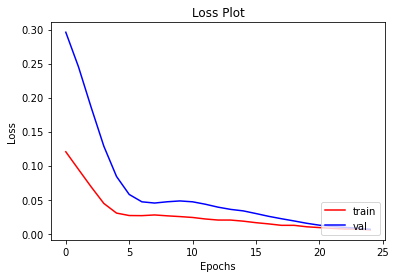

In [25]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

In [26]:
mse,rmse,r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("MSE =",mse)
print("RMSE =",rmse)
print("R2-Score =",r2_value)

MSE = 0.12725775403268338
RMSE = 0.3567320479473121
R2-Score = -9.822485150855975


In [27]:
# Get each date data
train_date = train_data.index
val_date = val_data.index
test_date = test_data.index[timesteps:]

# Bring back onto original values
train_sc = sc.inverse_transform(train)
val_sc = sc.inverse_transform(val)
test_sc = sc.inverse_transform(test)

# Create empty fill so predicted data fits with scaler dimension
zeros_shape = test.shape[0] - timesteps
num_x_variables = len(variables) - 1
empty_fill = np.zeros((zeros_shape, num_x_variables))

# Transform back into original value
pred = np.concatenate((empty_fill, predicted), axis=1)
pred = sc.inverse_transform(pred)

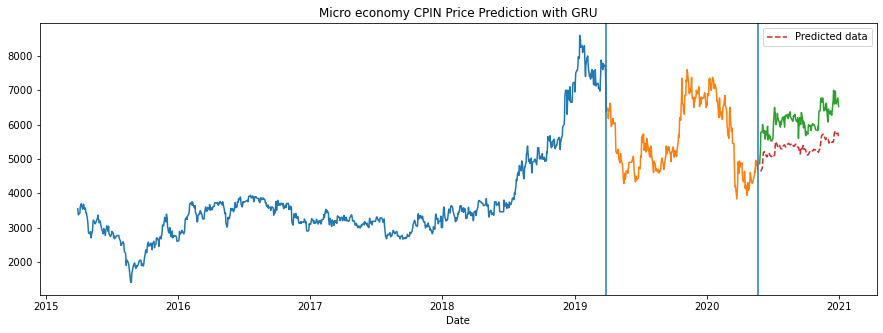

In [28]:
 # Figure size
plt.figure(figsize=(15, 5))

# Train data
plt.plot(train_date, train_sc[:, -1])

# Val data
plt.plot(val_date, val_sc[:, -1])

# Test data
plt.plot(test_data.index, test_sc[:,-1])
plt.plot(test_date, pred[:, -1], label='Predicted data', linestyle='--')

# Boundaries
plt.axvline(np.max(train_date))
plt.axvline(np.max(val_date))

# Attributes
plt.title('Micro economy CPIN Price Prediction with GRU')
plt.xlabel('Date')
plt.legend()
plt.show()

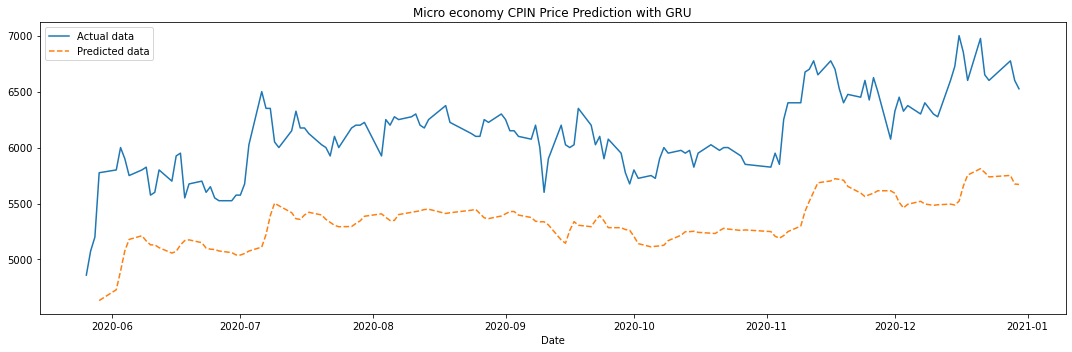

In [29]:
plt.figure(figsize=(15, 5))

# Test data
plt.plot(test_data.index, test_sc[:, -1], label='Actual data')
plt.plot(test_date, pred[:, -1], label='Predicted data', linestyle='--')

# Attributes
plt.title('Micro economy CPIN Price Prediction with GRU')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()

In [30]:
output = pd.DataFrame(pred, columns = ['Open','High','Low','PER', 'PBV', 'ROE', 'Close'])

In [31]:
output.to_csv('MicroOutput.csv', index = False)